In [12]:
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.io import decode_image
from pathlib import Path
device = torch.device('cuda')

In [ ]:
PLANT_CLASSES = [
    'Black-grass',
    'Charlock', 
    'Cleavers',
    'Common Chickweed',
    'Common wheat',
    'Fat Hen',
    'Loose Silky-bent',
    'Maize',
    'Scentless Mayweed',
    'Shepherds Purse',
    'Small-flowered Cranesbill',
    'Sugar beet'
]

class PlantDataset(Dataset):

    def __init__(self, rootDir, transform=None):
        self.rootDir = Path(rootDir)
        self.transforms = transform
        self.classes = PLANT_CLASSES
        self.classsToidx = {plant : idx for idx, plant in enumerate(PLANT_CLASSES)} #將classString轉成 index 的 dict

        self.samples = []
        self._load_samples()
    
    def _load_samples(self):
        """載入指定path中的資料 將'路徑'和label紀錄到samples中"""
        for class_name in self.classes:
            class_dir = self.rootDir / class_name
            if class_dir.exists():
                for img_path in class_dir.glob('*.png'):
                    self.samples.append((str(img_path), self.classsToidx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        img_path, label = self.samples[index]
        try:
            image = decode_image(img_path, mode='RGB')
        except Exception as e:
            print(f"無法載入圖片{img_path}:{e}")
        if self.transforms:
            image = self.transforms(image)
        return image, label

In [14]:
transform_train = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomResizedCrop(224), #resnet50標準輸入size
    v2.RandomHorizontalFlip(0.5),
    v2.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),

    v2.RandomRotation(15),
    v2.RandomGrayscale(p=0.1),

    v2.ToDtype(torch.float32, scale=True),

    v2.Normalize(
        mean=[0.485, 0.456, 0.406],#0~1 float計算的mean
        std=[0.229, 0.224, 0.225]
    )#ImageNet 資料的mean 跟 std
])

transform_val = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],#0~1 float計算的mean
        std=[0.229, 0.224, 0.225]
    )#ImageNet 資料的mean 跟 std
])

In [15]:
def create_dataloaders_with_split(data_dir, batch_size=64, num_workers=2, val_split=0.2):

    train_dir = data_dir / 'train'

    train_dataset = PlantDataset(rootDir=train_dir, transform=transform_train)
    val_dataset = PlantDataset(rootDir=train_dir, transform=transform_val)
    
    total_size = len(train_dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size

    train_indices, val_indices = random_split(
        #為了套不同的transfroms 用idx分割
        range(total_size), 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(val_dataset, val_indices)
    
    train_dataset.dataset.transforms = transform_train
    val_dataset.dataset.transforms = transform_val

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
    )

    return train_loader, val_loader

In [16]:
class TestDataset(Dataset):
    
    def __init__(self, rootDir, transform=None):
        self.rootDir = Path(rootDir)
        self.transforms = transform
        self.samples = []
        self._load_samples()
    
    def _load_samples(self):
        """載入測試資料夾中的所有圖片"""
        for img_path in self.rootDir.glob('*.png'):
            self.samples.append(str(img_path))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        img_path = self.samples[index]
        try:
            image = decode_image(img_path, mode='RGB')
        except Exception as e:
            print(f"❌ 無法載入圖片 {img_path}: {e}") 
        
        if self.transforms:
            image = self.transforms(image)
        
        filename = Path(img_path).name
        return image, filename

def create_test_dataloader(data_dir, batch_size=64, num_workers=2):
    """建立測試資料載入器"""
    
    test_dir = data_dir / 'test'
    
    test_dataset = TestDataset(
        rootDir=test_dir,
        transform=transform_val
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
    )
    
    return test_loader

In [17]:
data_dir = Path('./data')
train_loader, val_loader = create_dataloaders_with_split(data_dir, batch_size=32, num_workers=0)
test_loader = create_test_dataloader(data_dir, batch_size=32, num_workers=0)

In [7]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [8]:
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

def create_resnet50_model(num_classes=12):
    """建立 ResNet-50 模型"""
    
    # 🎯 載入預訓練模型
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

def create_resnet50_model_freeze(num_classes=12):
    """建立 ResNet-50 模型"""
    
    # 🎯 載入預訓練模型
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    for name, param in model.named_parameters():
        if any(layer in name for layer in ['conv1', 'bn1', 'layer1', 'layer2']):
            param.requires_grad = False
        else:
            param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

model = create_resnet50_model(num_classes=len(PLANT_CLASSES))
#model = create_resnet50_model_freeze(num_classes=len(PLANT_CLASSES))
model = model.to(device)

# 📊 顯示模型資訊
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📈 總參數量: {total_params:,}")
print(f"🎯 可訓練參數: {trainable_params:,}")

📈 總參數量: 23,532,620
🎯 可訓練參數: 23,532,620


In [9]:
criterion = nn.CrossEntropyLoss()
    
optimizer = Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0001  # L2 正則化
)
    
scheduler = StepLR(
    optimizer,
    step_size=7,    # 每 7 個 epoch 降低學習率
    gamma=0.1       # 學習率乘以 0.1
)

In [10]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """訓練一個 epoch"""
    
    model.train()  # 設定為訓練模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"🚂 Epoch {epoch} 訓練中...")
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # 📦 資料移到 GPU
        images, labels = images.to(device), labels.to(device)
        
        # 🔄 前向傳播
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 🔙 反向傳播
        loss.backward()
        optimizer.step()
        
        # 📊 統計
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # 📈 顯示進度
        if batch_idx % 10 == 0:
            print(f"  批次 {batch_idx}/{len(train_loader)}: "
                  f"Loss={loss.item():.4f}, "
                  f"Acc={100.*correct/total:.2f}%")
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_one_epoch(model, val_loader, criterion, device, epoch):
    """驗證一個 epoch"""
    
    model.eval()  # 設定為評估模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"✅ Epoch {epoch} 驗證中...")
    
    with torch.no_grad():  # 不計算梯度
        for images, labels in val_loader:
            # 📦 資料移到 GPU
            images, labels = images.to(device), labels.to(device)
            
            # 🔄 前向傳播
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 📊 統計
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


In [11]:
import numpy as np
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, restore_best_weights=True, 
                 save_path='best_model.pth', verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.save_path = save_path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.best_weights = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'🔔 EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_weights is not None:
                    model.load_state_dict(self.best_weights)
                    if self.verbose:
                        print('🔄 Restored best weights')
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'📉 Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        
        # 保存最佳權重到記憶體
        self.best_weights = model.state_dict().copy()
        self.val_loss_min = val_loss


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, num_epochs=20, save_path='best_model.pth', early_stopping_patience=10):
    """完整訓練流程"""
    
    print("🚀 開始訓練 ResNet-50")
    print("="*50)
    print(f"📊 訓練集批次數: {len(train_loader)}")
    print(f"📊 驗證集批次數: {len(val_loader)}")
    print(f"⏰ 總訓練輪數: {num_epochs}")
    print("="*50)
    
    # 📈 記錄訓練歷史
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    early_stopping = EarlyStopping(
        patience=early_stopping_patience,
        min_delta=0.001,
        restore_best_weights=True,
        save_path=save_path,
        verbose=True
    )
    
    best_val_acc = 0.0
    
    for epoch in range(1, num_epochs + 1):
        print(f"\n🔄 Epoch {epoch}/{num_epochs}")
        print("-" * 30)
        
        # 🚂 訓練階段
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, epoch
        )
        
        # ✅ 驗證階段
        val_loss, val_acc = validate_one_epoch(
            model, val_loader, criterion, device, epoch
        )
        
        # 📅 更新學習率
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # 📊 記錄結果
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 📈 顯示結果
        print(f"\n📊 Epoch {epoch} 結果:")
        print(f"  🚂 訓練 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  ✅ 驗證 - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        print(f"  📅 學習率: {current_lr:.6f}")
        
        # 💾 儲存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'history': history
            }, save_path)
            print(f"  🎯 新的最佳模型！驗證準確率: {val_acc:.2f}%")

        #做early stopping
        if early_stopping_patience > 0:
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                print(f"\n🛑 Early stopping triggered at epoch {epoch}!")
                print(f"🎯 最佳驗證準確率: {best_val_acc:.2f}%")
                break

    print(f"\n🎉 訓練完成！")
    print(f"🏆 最佳驗證準確率: {best_val_acc:.2f}%")
    print(f"💾 模型已儲存至: {save_path}")
    
    return history


# 🚀 開始訓練！
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=20,
    save_path='resnet50_plant_classifier.pth',
    early_stopping_patience=3
    )


🚀 開始訓練 ResNet-50
📊 訓練集批次數: 118
📊 驗證集批次數: 30
⏰ 總訓練輪數: 20

🔄 Epoch 1/20
------------------------------
🚂 Epoch 1 訓練中...
  批次 0/118: Loss=2.4686, Acc=6.25%
  批次 10/118: Loss=1.8412, Acc=23.01%
  批次 20/118: Loss=1.8852, Acc=28.87%
  批次 30/118: Loss=1.5187, Acc=33.06%
  批次 40/118: Loss=1.8619, Acc=36.05%
  批次 50/118: Loss=1.1716, Acc=40.20%
  批次 60/118: Loss=1.3633, Acc=43.44%
  批次 70/118: Loss=1.0274, Acc=45.73%
  批次 80/118: Loss=1.4657, Acc=47.80%
  批次 90/118: Loss=0.9680, Acc=49.48%
  批次 100/118: Loss=0.9298, Acc=50.96%
  批次 110/118: Loss=1.5536, Acc=51.83%
✅ Epoch 1 驗證中...

📊 Epoch 1 結果:
  🚂 訓練 - Loss: 1.4501, Acc: 52.20%
  ✅ 驗證 - Loss: 0.8041, Acc: 70.84%
  📅 學習率: 0.001000
  🎯 新的最佳模型！驗證準確率: 70.84%

🔄 Epoch 2/20
------------------------------
🚂 Epoch 2 訓練中...
  批次 0/118: Loss=1.1359, Acc=59.38%
  批次 10/118: Loss=0.9141, Acc=62.50%
  批次 20/118: Loss=0.8616, Acc=64.43%
  批次 30/118: Loss=1.0400, Acc=65.12%
  批次 40/118: Loss=0.9063, Acc=66.46%
  批次 50/118: Loss=0.9502, Acc=67.10%
  批次 60/11

KeyboardInterrupt: 

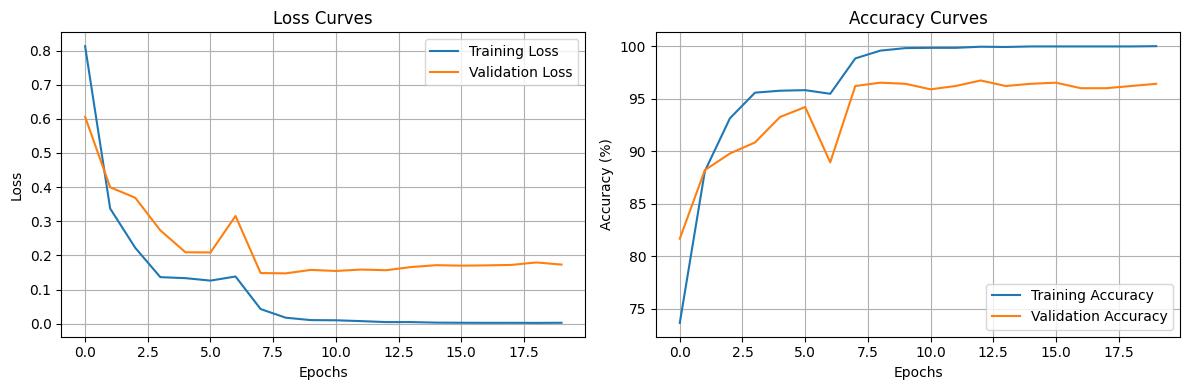

🔍 正在生成預測結果...


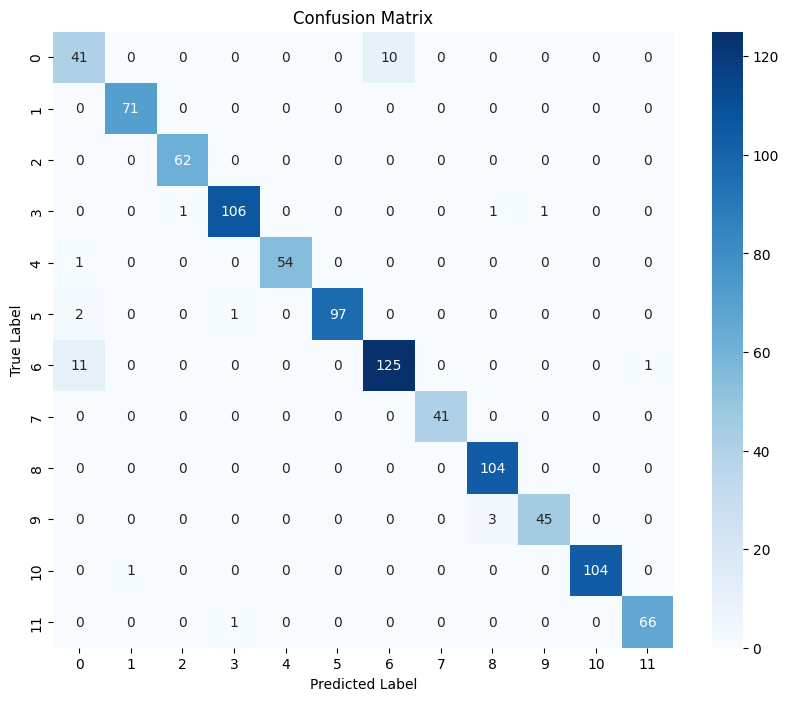

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_predictions(model, data_loader, device):
    """獲取模型在驗證集上的預測結果"""
    model.eval()
    all_preds = []
    all_labels = []
    
    print("🔍 正在生成預測結果...")
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# 簡單的 Loss 曲線
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 簡單的混淆矩陣
y_pred, y_true = get_predictions(model, val_loader, device)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [93]:
import pandas as pd
from tqdm import tqdm

def predict_test_dataset(model, test_loader, device, class_names, save_path='predictions.csv'):
    """對測試資料集進行預測並輸出 CSV"""
    
    print("🔍 開始預測測試資料集:")
    print("="*40)
    print(f"📊 測試批次數: {len(test_loader)}")
    print(f"📁 預測結果將保存至: {save_path}")
    print("="*40)
    
    model.eval()
    
    # 儲存預測結果
    predictions_list = []
    filenames_list = []
    confidences_list = []
    
    with torch.no_grad():
        # 使用 tqdm 顯示進度條
        for batch_idx, (images, filenames) in enumerate(tqdm(test_loader, desc="🚀 預測中")):
            images = images.to(device)
            
            # 前向傳播
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidences, predicted = torch.max(probabilities, 1)
            
            # 轉換為 CPU 並收集結果
            predicted = predicted.cpu().numpy()
            confidences = confidences.cpu().numpy()
            
            # 將預測類別索引轉換為類別名稱
            for i, (pred_idx, conf, filename) in enumerate(zip(predicted, confidences, filenames)):
                species_name = class_names[pred_idx]
                
                predictions_list.append(species_name)
                filenames_list.append(filename)
                confidences_list.append(conf)
    
    # 建立 DataFrame
    results_df = pd.DataFrame({
        'file': filenames_list,
        'species': predictions_list,
        'confidence': confidences_list
    })
    
    # 按檔名排序
    results_df = results_df.sort_values('file').reset_index(drop=True)
    
    # 保存 CSV（只包含 file 和 species 欄位，符合你的格式要求）
    final_df = results_df[['file', 'species']]
    final_df.to_csv(save_path, index=False)
    
    print(f"\n✅ 預測完成！")
    print(f"📊 總預測樣本數: {len(results_df)}")
    print(f"📁 結果已保存至: {save_path}")
    
    # 顯示預測統計
    print(f"\n📊 預測統計:")
    species_counts = results_df['species'].value_counts()
    for species, count in species_counts.items():
        percentage = (count / len(results_df)) * 100
        print(f"   {species}: {count} 張 ({percentage:.1f}%)")
    
    # 顯示信心度統計
    print(f"\n🎯 預測信心度統計:")
    print(f"   平均信心度: {results_df['confidence'].mean():.3f}")
    print(f"   最高信心度: {results_df['confidence'].max():.3f}")
    print(f"   最低信心度: {results_df['confidence'].min():.3f}")
    print(f"   高信心度 (>0.9): {(results_df['confidence'] > 0.9).sum()} 張")
    print(f"   低信心度 (<0.5): {(results_df['confidence'] < 0.5).sum()} 張")
    
    # 顯示前幾個預測結果作為範例
    print(f"\n📋 前 10 個預測結果:")
    print(final_df.head(10).to_string(index=False))
    
    return results_df, final_df

# 🚀 執行測試預測
def run_test_prediction():
    """執行完整的測試預測流程"""
    
    print("🚀 開始測試預測流程:")
    print("="*50)
    
    # 1. 載入最佳模型
    model_path = 'resnet50_plant_classifier.pth'
    print(f"📥 載入模型: {model_path}")
    
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ 模型載入成功! (最佳驗證準確率: {checkpoint['best_val_acc']:.2f}%)")
    except Exception as e:
        print(f"❌ 模型載入失敗: {e}")
        return None
    
    
    if len(test_loader) == 0:
        print("❌ 測試資料夾為空或無法讀取")
        return None
    
    print(f"📊 測試資料載入完成: {len(test_loader.dataset)} 張圖片")
    
    # 3. 進行預測
    results_df, final_df = predict_test_dataset(
        model=model,
        test_loader=test_loader,
        device=device,
        class_names=PLANT_CLASSES,
        save_path='test_predictions.csv'
    )
    
    return results_df, final_df

# 🎯 執行預測
prediction_results = run_test_prediction()


🚀 開始測試預測流程:
📥 載入模型: resnet50_plant_classifier.pth
✅ 模型載入成功! (最佳驗證準確率: 95.89%)
📊 測試資料載入完成: 794 張圖片
🔍 開始預測測試資料集:
📊 測試批次數: 13
📁 預測結果將保存至: test_predictions.csv


🚀 預測中: 100%|██████████| 13/13 [00:02<00:00,  4.48it/s]


✅ 預測完成！
📊 總預測樣本數: 794
📁 結果已保存至: test_predictions.csv

📊 預測統計:
   Loose Silky-bent: 120 張 (15.1%)
   Common Chickweed: 101 張 (12.7%)
   Scentless Mayweed: 88 張 (11.1%)
   Small-flowered Cranesbill: 80 張 (10.1%)
   Sugar beet: 79 張 (9.9%)
   Fat Hen: 62 張 (7.8%)
   Charlock: 62 張 (7.8%)
   Cleavers: 47 張 (5.9%)
   Shepherds Purse: 46 張 (5.8%)
   Black-grass: 40 張 (5.0%)
   Maize: 35 張 (4.4%)
   Common wheat: 34 張 (4.3%)

🎯 預測信心度統計:
   平均信心度: 0.976
   最高信心度: 1.000
   最低信心度: 0.288
   高信心度 (>0.9): 739 張
   低信心度 (<0.5): 2 張

📋 前 10 個預測結果:
         file                   species
0021e90e4.png Small-flowered Cranesbill
003d61042.png                   Fat Hen
007b3da8b.png                Sugar beet
0086a6340.png          Common Chickweed
00c47e980.png                Sugar beet
00d090cde.png          Loose Silky-bent
00ef713a8.png          Common Chickweed
01291174f.png                   Fat Hen
026716f9b.png          Loose Silky-bent
02cfeb38d.png          Loose Silky-bent
